# Speech Recognition with Neural Networks: Utterance to Phoneme Mapping


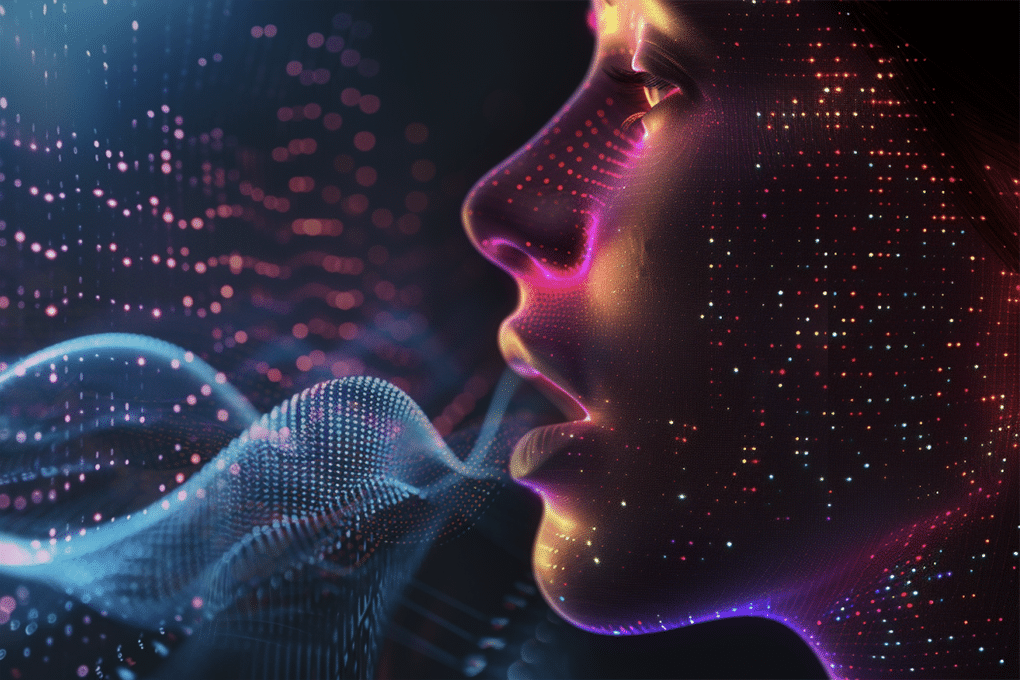

In this assignment, you'll build a sequence-to-sequence model that maps speech utterances to phoneme sequences. You'll implement a recurrent neural network architecture that processes speech feature vectors (MFCCs) and outputs corresponding phoneme sequences.

## Key Components

- **Data Processing**: Work with Mel-Frequency Cepstral Coefficients (MFCCs) and handle variable-length sequences through padding and packing
- **Neural Network Architecture**: Implement a model using basic CNNs for feature extraction, BiLSTMs for sequential modeling, and optional pyramidal BiLSTMs for downsampling
- **CTC Loss**: Train your model using Connectionist Temporal Classification to handle sequence alignment challenges
- **Decoding Strategies**: Explore both greedy search and beam search for phoneme sequence generation
- **Evaluation**: Use Levenshtein Distance to measure the accuracy of your predicted phoneme sequences
- **Submission**: Submit your results on kaggle for final evaluation.

This assignment will give you practical experience with sequence modeling techniques essential to speech recognition systems while exploring various architectural choices and optimization strategies.

# Installs

In [ ]:
!pip install torchinfo --quiet
!pip install python-Levenshtein --quiet

## Imports

In [ ]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import wandb
import torchaudio.transforms as tat
from torchaudio.models.decoder import cuda_ctc_decoder
import Levenshtein

from sklearn.metrics import accuracy_score
import gc

import glob

import zipfile
from tqdm.auto import tqdm
import os
import datetime


import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

# Google Drive

In [ ]:
# Uncomment this if you want to use Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Kaggle API Setup

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:

    f.write('{"username":"austinwindhamcmu","key":"986323f0ffef39adb8688f2f64d82992"}') # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

### Download Data (Chill out it will take a while😀)

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions download -c hw-3-p-2-automatic-speech-recognition-asr-11-785 # Download Data
!unzip -q hw-3-p-2-automatic-speech-recognition-asr-11-785.zip    # Unzip the dataset...

# Config

In [ ]:
import os

# Specify the directory path
folder_path = '/content/11785-S25-hw3p2/train-clean-100/mfcc'

# List files in the directory
file_list = os.listdir(folder_path)

# Count the number of files
number_of_files = len(file_list)

print(f"There are {number_of_files} files in the folder.")


In [ ]:
%%writefile config.yaml

# Subset of dataset to use (1.0 == 100% of data)
subset: 1.0
learning_rate: 0.002
epochs: 100
train_beam_width: 6
test_beam_width: 20
mfcc_features: 28 # DO NOT MODIFY

# Set embedding size (the dimensionality of the LSTM hidden state)
embed_size: 256   # {64,128,256} Try out higher embed_size if you have powerfull GPU(RAM) other than T4

batch_size: 128 # Increase if your device can handle it

encoder dropout: 0.2
lstm dropout: 0.2
decoder dropout: 0.2
wandb: True # Set to True if you want to use WanDB

freq_mask_param: 5
time_mask_param: 50

Name: "Student_Name" # Write your name here

In [ ]:
import yaml
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [ ]:
config

In [ ]:
BATCH_SIZE = config["batch_size"] # Define batch size from config
root = "/content/11785-S25-hw3p2" # Specify the directory to your root based on your environment

# Setup Vocabulary (DO NOT MODIFY)

In [ ]:
# ARPABET PHONEME MAPPING
# DO NOT CHANGE

CMUdict_ARPAbet = {
    "" : " ",
    "[SIL]": "-", "NG": "G", "F" : "f", "M" : "m", "AE": "@",
    "R"    : "r", "UW": "u", "N" : "n", "IY": "i", "AW": "W",
    "V"    : "v", "UH": "U", "OW": "o", "AA": "a", "ER": "R",
    "HH"   : "h", "Z" :
     "z", "K" : "k", "CH": "C", "W" : "w",
    "EY"   : "e", "ZH": "Z", "T" : "t", "EH": "E", "Y" : "y",
    "AH"   : "A", "B" : "b", "P" : "p", "TH": "T", "DH": "D",
    "AO"   : "c", "G" : "g", "L" : "l", "JH": "j", "OY": "O",
    "SH"   : "S", "D" : "d", "AY": "Y", "S" : "s", "IH": "I",
    "[SOS]": "[SOS]", "[EOS]": "[EOS]"
}


CMUdict = list(CMUdict_ARPAbet.keys())
ARPAbet = list(CMUdict_ARPAbet.values())

PHONEMES = CMUdict[:-2] #To be used for mapping original transcripts to integer indices
LABELS = ARPAbet[:-2] #To be used for mapping predictions to strings

OUT_SIZE = len(PHONEMES) # Number of output classes
print("Number of Phonemes:", OUT_SIZE)

# Indexes of BLANK and SIL phonemes
BLANK_IDX=CMUdict.index('')
SIL_IDX=CMUdict.index('[SIL]')

print("Index of Blank:", BLANK_IDX)
print("Index of [SIL]:", SIL_IDX)

### Sample data inspection & sanity check

In [ ]:
test_mfcc = f"{root}/train-clean-100/mfcc/103-1240-0000.npy"
test_transcript = f"{root}/train-clean-100/transcript/103-1240-0000.npy"

mfcc = np.load(test_mfcc)
transcript = np.load(test_transcript)[1:-1] #Removed [SOS] and [EOS]

print("MFCC Shape:", mfcc.shape)
print("\nMFCC:\n", mfcc)
print("\nTranscript shape:", transcript.shape)

print("\nOriginal Transcript:\n", transcript)

# map the loaded transcript (from phonemes representation) to corresponding labels representation
mapped_transcript = [CMUdict_ARPAbet[k] for k in transcript]
print("\nTranscript mapped from PHONEMES representation to LABELS representation:\n", mapped_transcript)

# Mapping list of PHONEMES to list of Integer indexes
map = {k: i for i, k in enumerate(PHONEMES)}
print("\nMapping list of PHONEMES to list of Integer indexes:\n", map)



# Dataset and Dataloader

### Train Data

In [ ]:
class AudioDataset(torch.utils.data.Dataset):

    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    #TODO
    def __init__(self, partition = "Train", augmentation = True):
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''
        self.augmentation = augmentation
        self.partition = partition

        self.PHONEMES = PHONEMES
        self.subset = config['subset']

        # TODO
        # Define the directories containing MFCC and transcript files
        if self.partition == "Train":

          self.mfcc_dir = "/content/11785-S25-hw3p2/train-clean-100/mfcc" #TODO
          self.transcript_dir = "/content/11785-S25-hw3p2/train-clean-100/transcript" #TODO
        else:
            self.mfcc_dir = "/content/11785-S25-hw3p2/dev-clean/mfcc" #TODO
            self.transcript_dir = "/content/11785-S25-hw3p2/dev-clean/transcript" #TODO


        # List all files in the directories. Remember to sort the files
        self.mfcc_files = sorted(glob.glob(os.path.join(self.mfcc_dir, "*.npy"))) #TODO
        self.transcript_files = sorted(glob.glob(os.path.join(self.transcript_dir, "*.npy"))) #TODO

        # Compute size of data subset
        subset_size = int(self.subset * len(self.mfcc_files))

        # Select subset of data to use
        self.mfcc_files = self.mfcc_files[:subset_size]
        self.transcript_files = self.transcript_files[:subset_size]

        assert(len(self.mfcc_files) == len(self.transcript_files))

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length = len(self.mfcc_files) #TODO

        #TODO
        # CREATE AN ARRAY TO STORE ALL PROCESSED MFCCS AND TRANSCRIPTS
        # LOAD ALL MFCCS AND CORRESPONDING TRANSCRIPTS AND DO THE NECESSARY PRE-PROCESSING
          # HINTS:
          # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
          # REMEMBER TO REMOVE [SOS] AND [EOS] FROM TRANSCRIPTS
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''

        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS

        # Create arrays to store processed MFCCs and transcripts
        self.mfcc_data = []
        self.transcript_data = []

        self.phoneme_map = {phoneme: idx for idx, phoneme in enumerate(self.PHONEMES)}


        for i in tqdm(range(self.length)):  # Loop through each file
            # Load MFCC
            mfcc = np.load(self.mfcc_files[i])

            # Apply Z-score normalization (mean-variance normalization)
            mfcc = (mfcc - np.mean(mfcc, axis=0, keepdims=True)) / (np.std(mfcc, axis=0, keepdims=True) + 1e-8)


            # Convert to PyTorch tensor
            mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)

            # Load transcript and remove [SOS] and [EOS]
            transcript = np.load(self.transcript_files[i])[1:-1]

            # Convert phonemes to numerical labels
            transcript_indices = [self.phoneme_map[phoneme] for phoneme in transcript]

            # Convert transcript to PyTorch tensor
            transcript_tensor = torch.tensor(transcript_indices, dtype=torch.long)

            # Store preprocessed data
            self.mfcc_data.append(mfcc_tensor)
            self.transcript_data.append(transcript_tensor)



    def __len__(self):

        '''
        TODO: What do we return here?
        '''

        return self.length #TODO


    def __getitem__(self, ind):

        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.

        '''

        mfcc = self.mfcc_data[ind] #TODO
        transcript = self.transcript_data[ind] #TODO

        # NOTE: Remember to convert mfcc and transcripts to tensors here, if not done already in __init__
        return mfcc, transcript


    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''

        # Extract batch of input MFCCs and batch of output transcripts separately
        batch_mfcc, batch_transcript = zip(*batch) #TODO

        # Store original lengths of the MFCCS and transcripts in the batches
        lengths_mfcc = torch.tensor([mfcc.shape[0] for mfcc in batch_mfcc]) #TODO
        lengths_transcript = torch.tensor([transcript.shape[0] for transcript in batch_transcript]) #TODO

        # Pad the MFCC sequences and transcripts
        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        # Note: (resulting shape of padded MFCCs: [batch, time, freq])
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True) #TODO
        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True) #TODO note had padding value = blank index


        # TODO: You may apply some transformations, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        #                     -> Time & Freq. Masking functions both expect input of shape (..., freq, time),
        #                        So permute your input dimensions appropriately before & after using these functions.

        if self.augmentation and np.random.rand() < 0.70:
            batch_mfcc_pad = batch_mfcc_pad.permute(0, 2, 1)  # Convert to (batch, features, time) for torchaudio.transforms
            time_mask = tat.TimeMasking(time_mask_param=70)
            freq_mask = tat.FrequencyMasking(freq_mask_param=7)
            batch_mfcc_pad = time_mask(batch_mfcc_pad)
            batch_mfcc_pad = freq_mask(batch_mfcc_pad)
            batch_mfcc_pad = batch_mfcc_pad.permute(0, 2, 1)

        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)



### Test Data

In [ ]:
# TODO
# Food for thought -> Do you need to apply transformations in this test dataset class?
class AudioDatasetTest(torch.utils.data.Dataset):
    def __init__(self):
        '''
        Initializes the test dataset (only MFCCs, no transcripts).
        '''

        # self.subset = config['subset']

        # Define directory (only MFCCs exist)
        self.mfcc_dir = "/content/11785-S25-hw3p2/test-clean/mfcc"

        # List and sort files
        self.mfcc_files = sorted(glob.glob(os.path.join(self.mfcc_dir, "*.npy")))

        # Apply subset selection
        # subset_size = int(self.subset * len(self.mfcc_files))

        # Dataset length
        self.length = len(self.mfcc_files)

        # Store processed MFCCs
        self.mfcc_data = []

        for i in tqdm(range(self.length)):  # Loop through each file
            # Load MFCC
            mfcc = np.load(self.mfcc_files[i])

            # Apply Z-score normalization
            mfcc = (mfcc - np.mean(mfcc, axis=0, keepdims=True)) / np.std(mfcc, axis=0, keepdims=True)


            # Convert to PyTorch tensor
            mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)

            # Store MFCC data
            self.mfcc_data.append(mfcc_tensor)

    def __len__(self):
        '''
        Returns the length of the test dataset.
        '''
        return self.length

    def __getitem__(self, ind):
        '''
        Returns MFCC coefficients (no transcript).
        '''
        mfcc = self.mfcc_data[ind]
        return mfcc  # Only return MFCC (no transcript)

    def collate_fn(self, batch):
        '''
        Processes batch data: pads sequences and returns metadata.
        '''

        lengths_mfcc = torch.tensor([mfcc.shape[0] for mfcc in batch])

        # Pad sequences
        batch_mfcc_pad = pad_sequence(batch, batch_first=True) # had padding value = 0


        return batch_mfcc_pad, lengths_mfcc



In [ ]:
# To free up ram
import gc
gc.collect()

### Create Datasets & Data loaders

In [ ]:
# Create objects for the dataset classes
train_data = AudioDataset(augmentation = True, partition = "Train") # TODO: Fill in the required parameters
val_data = AudioDataset(augmentation = False, partition = "Val") # TODO: You can either use the same class for train data with some modifications or make a new one :)
test_data = AudioDatasetTest() # TODO: Fill in the required parameters

In [ ]:
# Do NOT forget to pass in the collate function as an argument while creating the dataloader
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=train_data.collate_fn,
    pin_memory=True,
    num_workers=4
)

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=val_data.collate_fn,
    pin_memory=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=test_data.collate_fn,
    pin_memory=True,
    num_workers=4
) # these are all todos !!!!!!!!!!!!!!!!

print("Batch size: ", config['batch_size'])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

In [ ]:
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

# Visualize Data

Note: In the visualized graph, do not confuse padded regions of the MFCC sequences with time/freq augmentation masks. Remember all MFCCs were padded to the maximum sequence length

In [ ]:
import matplotlib.pyplot as plt

def visualize_batch(loader, title="Dataset Visualization", num_samples=2):
    """
    Visualizes MFCC features from a single batch of data.

    Args:
        loader (DataLoader): DataLoader object (for train, val, or test).
        title (str): Title of the plot.
        num_samples (int): Number of samples to visualize from the batch.
    """
    # Get one batch from the loader.
    batch = next(iter(loader))

    # The collate_fn we defined in the dataset class returns a tuple, where the first element is the padded MFCC tensor.
    mfcc_batch = batch[0] if isinstance(batch, (tuple, list)) else batch

    # Limit to a few samples.
    num_samples = min(num_samples, mfcc_batch.size(0))

    # Create subplots.
    fig, axes = plt.subplots(1, num_samples, figsize=(15,6))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        # Each MFCC tensor is of shape [time, frequency].
        # Transpose for visualization: time on x-axis, features on y-axis.
        mfcc_img = mfcc_batch[i].cpu().numpy().T
        im = axes[i].imshow(mfcc_img, origin="lower", aspect="auto", cmap="viridis")
        axes[i].set_title(f"Sample {i}")
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("MFCC Coefficient")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize batches of data
visualize_batch(train_loader, title="Training Dataset MFCCs (with Time & Frequency Masking)")


# Network

## Basic network (Optional)

This is a basic block for understanding, you can skip this and move to pBLSTM one

In [ ]:
# torch.cuda.empty_cache()

# class Network(nn.Module):

#     def __init__(self):

#         super(Network, self).__init__()

#         # TODO: Adding some sort of embedding layer or feature extractor might help performance.
#         # You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
#         # Food for thought -> What type of Conv layers can be used here?
#         #                  -> What should be the size of input channels to the first layer?
#         self.embedding = _________________________ #TODO

#         # TODO : look up the documentation. You might need to pass some additional parameters.
#         self.lstm = nn.LSTM(input_size = __________________, hidden_size = 256, num_layers = 1) #TODO

#         self.classification = nn.Sequential(
#             #TODO: Linear layer with in_features from the lstm module above and out_features = OUT_SIZE
#         )


#         self.logSoftmax =__________________ #TODO: Apply a log softmax here. Which dimension would apply it on ?

#     def forward(self, x, lx):
#         #TODO
#         # The forward function takes 2 parameter inputs here. Why?
#         # Refer to the handout for hints
#         pass


## Initialize Basic Network
(If trying out the basic Network)

In [ ]:
# torch.cuda.empty_cache()

# model = Network().to(device)
# print(model)


## ASR Network
We define everything we need for the ASR model in separate classes, and put them all together in the end

#### Permute class

In [ ]:
class Permute(torch.nn.Module):
    '''
    Used to transpose/permute the dimensions of an MFCC tensor.
    '''
    def forward(self, x):
        return x.transpose(1, 2)

#### Pyramidal Bi-LSTM (pBLSTM) class

In [ ]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input?
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''

    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = nn.LSTM(input_size=input_size*2, hidden_size=hidden_size, bidirectional=True) # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size

    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        x, x_lens = pad_packed_sequence(x_packed, batch_first=True)

        # TODO: Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        x, x_lens = self.trunc_reshape(x, x_lens)

        # TODO: Pack Padded Sequence. What output(s) would you get?
        x = pack_padded_sequence(x,x_lens.cpu(), batch_first=True, enforce_sorted=False)

        # TODO: Pass the sequence through bLSTM
        x, nothing = self.blstm(x)

        # What do you return?
        return x #TODO


    def trunc_reshape(self, x, x_lens):

        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        # exclude last timestep if odd
        if x.shape[1] % 2 == 1:
            x = x[:, :-1, :]
            x_lens = x_lens-1


        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        x = x.reshape(x.shape[0], x.shape[1] // 2, x.shape[2] * 2)

        # TODO: Reduce lengths by the same downsampling factor
        x_lens = x_lens// 2
        x_lens = x_lens.to(torch.int64)

        return x, x_lens

In [ ]:
# # Test the pBLSTM module

# batch_size = 4
# time_steps = 10  # Needs to be even or will be truncated
# feature_dim = 32
# hidden_size = 64

# # Fake input data
# fake_x = torch.randn(batch_size, time_steps, feature_dim)
# fake_x_lens = torch.tensor([10, 8, 6, 4])  # Different lengths

# # Pack sequence
# fake_x_packed = pack_padded_sequence(fake_x, fake_x_lens, batch_first=True, enforce_sorted=False)

# # Initialize pBLSTM and pass through it
# pblstm = pBLSTM(input_size=feature_dim, hidden_size=hidden_size)
# output_packed = pblstm(fake_x_packed)

# # Unpack output for checking
# output, output_lens = pad_packed_sequence(output_packed, batch_first=True)

# print(f"Output shape: {output.shape}")  # Expect (batch_size, new_time_steps, hidden_size * 2)
# print(f"Output lengths: {output_lens}")  # Expect downsampled lengths


#### Util for LSTM


In [ ]:
class LSTMWrapper(torch.nn.Module):
    '''
    Used to get only output of lstm, not the hidden states.
    '''
    def __init__(self, lstm):
        super(LSTMWrapper, self).__init__()
        self.lstm = lstm

    def forward(self, x):
        output, _ = self.lstm(x)
        return output

#### Encoder class

In [ ]:
class Encoder(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Encoder, self).__init__()


        # TODO: You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
        # Food for thought -> What type of Conv layers can be used here?
        #                  -> What should be the size of input channels to the first layer?
        self.embedding = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=2, stride=1, padding=1), #TODO # CHECK
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128),
            torch.nn.Conv1d(in_channels=128, out_channels=256, kernel_size=2, stride=1, padding=1)
        )#TODO

        # TODO:
        self.BLSTMs = LSTMWrapper(
            # TODO: Look up the documentation. You might need to pass some additional parameters.
            torch.nn.LSTM(input_size= 256, hidden_size=encoder_hidden_size, num_layers=2,
                          bidirectional=True,
                          batch_first= True) #TODO
          )

        self.pBLSTMs = torch.nn.Sequential( # How many pBLSTMs are required?
            # TODO: Fill this up with pBLSTMs - What should the input_size be?
            # Hint: You are downsampling timesteps by a factor of 2, upsampling features by a factor of 2 and the LSTM is bidirectional)
            # Optional: Dropout/Locked Dropout after each pBLSTM (Not needed for early submission)
            # https://github.com/salesforce/awd-lstm-lm/blob/dfd3cb0235d2caf2847a4d53e1cbd495b781b5d2/locked_dropout.py#L5
            # ...
            # ...
            pBLSTM(input_size=encoder_hidden_size * 2, hidden_size=encoder_hidden_size), # First pBLSTM
            pBLSTM(input_size=encoder_hidden_size * 2, hidden_size=encoder_hidden_size)  # Second pBLSTM
            # pBLSTM(input_size=encoder_hidden_size * 2, hidden_size=encoder_hidden_size)
        )

    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader

        # TODO: Call the embedding layer
        #x = self.embedding(x.permute(0, 2, 1))  # Conv1d expects (batch, features, time)
        x = x.permute(0,2,1)
        x = self.embedding(x)
        x = x.permute(0,2,1)

        # TODO: Pack Padded Sequence
        x_packed = pack_padded_sequence(x, x_lens.cpu().to(torch.int64), batch_first=True, enforce_sorted=False)

        # TODO: Pass Sequence through the Bi-LSTM layer
        x_packed = self.BLSTMs(x_packed)

        # TODO: Pass Sequence through the pyramidal Bi-LSTM layer
        x_packed = self.pBLSTMs(x_packed)

        # TODO: Pad Packed Sequence
        encoder_outputs, encoder_lens = pad_packed_sequence(x_packed, batch_first=True)

        # Remember the number of output(s) each function returns

        return encoder_outputs, encoder_lens

In [ ]:
# # Fake input data
# batch_size = 4
# time_steps = 100  # Sequence length (varies per sample)
# mfcc_features = 28  # Input feature size
# hidden_size = 256  # Arbitrary choice for encoder hidden size

# # Create random input (simulating MFCC features)
# fake_x = torch.randn(batch_size, time_steps, mfcc_features)

# # Create random sequence lengths (sorted in descending order)
# fake_x_lens = torch.randint(80, 100, (batch_size,)).tolist()  # Random sequence lengths
# fake_x_lens = torch.tensor(sorted(fake_x_lens, reverse=True))  # Sorting to match packing behavior

# # Initialize the encoder
# encoder = Encoder(input_size=mfcc_features, encoder_hidden_size=hidden_size)

# # Forward pass through the encoder
# with torch.no_grad():
#     encoder_outputs, encoder_lens = encoder(fake_x, fake_x_lens)

# # Print debug info
# print(f"Final Encoder Output Shape: {encoder_outputs.shape}")
# print(f"Final Encoder Lengths Shape: {encoder_lens.shape}")
# print(encoder_outputs[0, :5, :10])  # Check first few values



#### Decoder class

In [ ]:
# class LockedDropout(torch.nn.Module):
#     def __init__(self, dropout):
#         super().__init__()
#         self.dropout = dropout

#     def forward(self, x):
#         if not self.training or self.dropout == 0:
#             return x
#         mask = x.new_empty(1, x.size(1), x.size(2)).bernoulli_(1 - self.dropout)
#         mask = mask.div_(1 - self.dropout)
#         mask = mask.expand_as(x)
#         return x * mask


In [ ]:
class Decoder(torch.nn.Module):

    def __init__(self, embed_size, output_size= 41):
        super().__init__()

        self.mlp = torch.nn.Sequential(

            Permute(),
            torch.nn.BatchNorm1d(2 * embed_size),
            Permute(),

            #TODO define your MLP arch. Refer HW1P2
            #Use Permute Block before and after BatchNorm1d() to match the size
            #Now you can stack your MLP layers
            # do i need more?
            torch.nn.Linear(2 * embed_size, embed_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),

            Permute(),
            torch.nn.BatchNorm1d(embed_size),
            Permute(),

            torch.nn.Linear(embed_size, embed_size // 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(embed_size // 2, 256),
            torch.nn.ReLU(),

            torch.nn.Linear(256, output_size)

        )

        self.softmax = torch.nn.LogSoftmax(dim=2)


    def forward(self, encoder_out):

        #TODO: Call your MLP

        out = self.mlp(encoder_out)

        #TODO: Think about what should be the final output of the decoder for classification
        out = self.softmax(out)

        return out


# class Decoder(torch.nn.Module):

#     def __init__(self, embed_size, output_size=41):
#         super().__init__()

#         # TODO: Define your MLP arch. Refer HW1P2
#         # Use Permute Block before and after BatchNorm1d() to match the size

#         self.lockdrop1 = LockedDropout(0.3)  # First locked dropout layer
#         self.lockdrop2 = LockedDropout(0.3)  # Second locked dropout layer

#         self.mlp1 = torch.nn.Sequential(
#             Permute(),
#             torch.nn.BatchNorm1d(2 * embed_size),
#             Permute(),
#             torch.nn.Linear(2 * embed_size, embed_size),
#             torch.nn.ReLU()
#         )

#         self.mlp2 = torch.nn.Sequential(
#             Permute(),
#             torch.nn.BatchNorm1d(embed_size),
#             Permute(),
#             torch.nn.Linear(embed_size, embed_size // 2),
#             torch.nn.ReLU()
#         )

#         self.final_mlp = torch.nn.Sequential(
#             torch.nn.Linear(embed_size // 2, 256),
#             torch.nn.ReLU(),
#             torch.nn.Linear(256, output_size)
#         )

#         self.softmax = torch.nn.LogSoftmax(dim=2)

#     def forward(self, encoder_out):
#         # TODO: Call your MLP

#         out = self.mlp1(encoder_out)
#         out = self.lockdrop1(out)

#         out = self.mlp2(out)
#         out = self.lockdrop2(out)

#         out = self.final_mlp(out)

#         # TODO: Think about what should be the final output of the decoder for classification
#         out = self.softmax(out)

#         return out


#### ASR Model Class

In [ ]:
class ASRModel(torch.nn.Module):

    def __init__(self, input_size, embed_size= 192, output_size= len(PHONEMES)):
        super().__init__()

        # Initialize encoder and decoder
        self.encoder        = Encoder(input_size= input_size, encoder_hidden_size= embed_size) # TODO: Initialize Encoder
        self.decoder        = Decoder(embed_size= embed_size, output_size= output_size) # TODO: Initialize Decoder


    def forward(self, x, lengths_x):

        encoder_out, encoder_lens = self.encoder(x, lengths_x)

        decoder_out = self.decoder(encoder_out)

        return decoder_out, encoder_lens

## Initialize ASR Network

In [ ]:
model = ASRModel(
    input_size  = config["mfcc_features"],  #TODO,
    embed_size  = 256, #TODO
    output_size = len(PHONEMES)
).to(device)


# # Create fake MFCC input: (batch_size, time_steps, mfcc_features)
# fake_x = torch.randn(16, 100, config["mfcc_features"]).to(device)  # Simulating 16 utterances
# fake_lx = torch.randint(80, 100, (16,)).cpu().to(torch.int64)  # Random lengths for sequences

# # Forward pass through the model
# with torch.no_grad():
#     fake_output, fake_output_lengths = model(fake_x, fake_lx)

# print(f"Final Output Shape: {fake_output.shape}")
# print(f"Final Output Lengths Shape: {fake_output_lengths.shape}")


In [ ]:
summary(model, input_data=[x.to(device), lx.to(device)])

# Training Config
Initialize Loss Criterion, Optimizer, CTC Beam Decoder, Scheduler, Scaler (Mixed-Precision), etc

In [ ]:
# TODO: Define CTC loss as the criterion. How would the losses be reduced?
criterion = torch.nn.CTCLoss(blank=0, reduction="mean", zero_infinity=True) #TODO
# CTC Loss: https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html
# Refer to the handout for hints

optimizer =  torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay= 0) #TODO: What goes in here? aaaaaah, cnage htis

# TODO: Declare the decoder. Use the PyTorch Cuda CTC Decoder to decode phonemes
# CTC Decoder: https://pytorch.org/audio/2.1/generated/torchaudio.models.decoder.cuda_ctc_decoder.html
decoder = cuda_ctc_decoder(tokens=LABELS, nbest=1, beam_size=config['train_beam_width']) #TODO

# TODO:
scheduler =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'], eta_min=0.0001) #TODO

# Mixed Precision, if you need it
scaler = torch.cuda.amp.GradScaler()

### Decode Prediction

In [ ]:
def decode_prediction(output, output_lens, decoder, PHONEME_MAP = LABELS):

    # Look at docs for CUDA_CTC_DECODER for more info on how it was used here:
    # https://pytorch.org/audio/main/tutorials/asr_inference_with_cuda_ctc_decoder_tutorial.html
    output = output.contiguous()
    output_lens = output_lens.to(torch.int32).contiguous()
    beam_results = decoder(output, output_lens.to(torch.int32)) #lengths - list of lengths

    pred_strings                    = []

    for i in range(len(beam_results)):
        # Create the prediction from the output of the cuda_ctc_decoder. Don't forget to map it using PHONEMES_MAP.
        # NOTE: PHONEMES_MAP should be the phoneme LABELS instead, as defined above as LABELS
        # Get the top prediction for each sequence in the batch
        top_beam_results = beam_results[i][0].tokens

        # TODO: Map the sequence of indices to actual phoneme LABELS and join them into a string
        # Append to predited strings list after joining

        # TODO: Map the sequence of indices to actual phoneme LABELS and join them into a string
        pred_string = ''.join([PHONEME_MAP[idx] for idx in top_beam_results]) # CHECK

        # Append to predited strings list after joining
        pred_strings.append(pred_string)

    return pred_strings

def calculate_levenshtein(output, label, output_lens, label_lens, decoder, PHONEME_MAP= LABELS): # y - sequence of integers

    dist            = 0
    batch_size      = label.shape[0]

    pred_strings    = decode_prediction(output, output_lens, decoder, PHONEME_MAP)

    for i in range(batch_size):
        # TODO: Get predicted string and label string for each element in the batch
        label_indices = label[i][:label_lens[i]].tolist()
        label_string = "".join([PHONEME_MAP[idx] for idx in label_indices]) # TODO
        pred_string = pred_strings[i]# TODO: Predicted string from decode_prediction

        dist += Levenshtein.distance(pred_string, label_string)

    # Average the distance over the batch
    dist /= batch_size # Think about why we are doing this
    return dist

In [ ]:
torch.cuda.empty_cache()
gc.collect()

## Test Implementation

In [ ]:
# test code to check shapes

model.eval()
for i, data in enumerate(val_loader, 0):
    x, y, lx, ly = data
    x, y = x.to(device), y.to(device)
    lx, ly = lx.to(device), ly.to(device)
    h, lh = model(x, lx)
    print(h.shape)
    h = torch.permute(h, (1, 0, 2))
    print(h.shape, y.shape)
    loss = criterion(h, y, lh, ly)
    print(loss)

    print(calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh.to(device), ly, decoder, LABELS))

    del x, y, lx, ly, h, lh, loss
    torch.cuda.empty_cache()

    break

    print("here")

## WandB

In [ ]:
# Use wandb? Resume Training?
USE_WANDB = config['wandb']

RESUME_LOGGING = False # Set this to true if you are resuming training from a previous run

# Create your wandb run

run_name = '{}_early_submission'.format(config['Name'])

# If you are resuming an old run
if USE_WANDB:

    wandb.login(key="b80b7cba89b1aec2ae77ac34a553f5f44774c157") #TODO

    if RESUME_LOGGING:
        run = wandb.init(
            id     = "", ### Insert specific run id here if you want to resume a previous run
            resume = "must", ### You need this to resume previous runs
            project = "hw3p2-ablations", ### Project should be created in your wandb
            settings = wandb.Settings(_service_wait=300)
        )


    else:
        run = wandb.init(
            name    = run_name, ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True, ### Allows reinitalizing runs when you re-run this cell
            project = "hw3p2-ablations", ### Project should be created in your wandb account
            config  = config ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)
        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### log it in your wandb run with wandb.save()
        wandb.save('model_arch.txt')

# Training Functions

In [ ]:
# Train function
def train_model(model, train_loader, criterion, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    total_loss = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)
        lx, ly = lx.to(device), ly.to(device)

        with torch.cuda.amp.autocast():
            h, lh = model(x, lx)
            h = torch.permute(h, (1, 0, 2))
            loss = criterion(h, y, lh, ly)

        total_loss += loss.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() # This is something added just for FP16

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close() # You need this to close the tqdm bar

    return total_loss / len(train_loader)


# Eval function
def validate_model(model, val_loader, decoder, phoneme_map= LABELS):

    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    total_loss = 0
    vdist = 0

    for i, data in enumerate(val_loader):

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)
        lx, ly = lx.to(device), ly.to(device)

        with torch.inference_mode():
            h, lh = model(x, lx)
            h = torch.permute(h, (1, 0, 2))
            loss = criterion(h, y, lh, ly)

        total_loss += loss.item()
        vdist += calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh.to(device), ly, decoder, phoneme_map)

        batch_bar.set_postfix(loss="{:.04f}".format(float(total_loss / (i + 1))), dist="{:.04f}".format(float(vdist / (i + 1))))

        batch_bar.update()

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close()
    total_loss = total_loss/len(val_loader)
    val_dist = vdist/len(val_loader)
    return total_loss, val_dist


### Model Saving & Loading functions

In [ ]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path
    )

def load_model(path, model, optimizer= None, scheduler= None, metric='valid_dist'):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    print("\nResuming training from epoch:", epoch)
    print('----------------------------------------\n')
    print("Epochs left: ", config['epochs'] - epoch)
    print("Optimizer: \n", optimizer)
    print("Current Schedueler T_cur:", scheduler.T_cur)

    print("Best Val Dist:", metric)

    return [model, optimizer, scheduler, epoch, metric]

## Training Loop

In [ ]:
# Instantiate variables used in training loop
last_epoch_completed = 0
best_lev_dist = float("inf")

#### Uncomment this if resuming training from model checkpoint

In [ ]:
# RESUME_TRAINING = True # Set this to true if you are resuming training from a mpdel checkpoint

# if RESUME_TRAINING:

#     checkpoint_path = ''
#     checkpoint = load_model(checkpoint_path, model, optimizer, scheduler, metric='valid_dist')

#     last_epoch_completed = checkpoint[3]
#     best_lev_dist = checkpoint[4]

In [ ]:
# Set up checkpoint directories and WanDB logging watch
checkpoint_root = os.path.join(os.getcwd(), 'checkpoints')
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(model, log="all")

checkpoint_best_model_filename = 'checkpoint-best-model.pth'
checkpoint_last_epoch_filename = 'checkpoint-last-epoch.pth'
epoch_model_path = os.path.join(checkpoint_root, checkpoint_last_epoch_filename)
best_model_path = os.path.join(checkpoint_root, checkpoint_best_model_filename)

# WanDB log watch
if config['wandb']:
  wandb.watch(model, log="all")


In [ ]:
# Clear RAM for storage before you start training
torch.cuda.empty_cache()
gc.collect()

#### Iterate over the number of epochs to train and evaluate your model


In [ ]:
#TODO: Please complete the training loop

for epoch in range(last_epoch_completed, config['epochs']):

    print("\nEpoch: {}/{}".format(epoch + 1, config['epochs']))

    curr_lr = optimizer.param_groups[0]['lr'] #TODO

    train_loss = train_model(model, train_loader, criterion, optimizer) #TODO
    valid_loss, valid_dist = validate_model(model, val_loader, decoder) #TODO

    # NOTE: Pass in the appropriate argument based on your chosen scheduler
    #       -> Some schedulers require a metric, while others require the current epoch
    #       -> Some schedulers do not require any argument to be passed in
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
    print("\tVal Dist {:.04f}\t Val Loss {:.04f}".format(valid_dist, valid_loss))

    if config['wandb']:
        wandb.log({
            'train_loss': train_loss,
            'valid_dist': valid_dist,
            'valid_loss': valid_loss,
            'lr': curr_lr
    })

    # Save last epoch model
    save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, epoch_model_path)
    if config['wandb']:
        wandb.save(epoch_model_path)
    print("Saved epoch model")

    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, best_model_path)
        if config['wandb']:
            wandb.save(best_model_path)
        print("Saved best val model")

# You may find it interesting to explore Wandb Artifacts to version your models

# Finish Wandb run
if config['wandb']:
    run.finish()


# Generate Predictions and Submit to Kaggle

In [ ]:
#TODO: Make predictions

# Follow the steps below:
# 1. Create a new object for CUDA_CTC_DECODER with larger number of beams (why larger?)
# 2. Get prediction string by decoding the results of the beam decoder


test_decoder = cuda_ctc_decoder(tokens=LABELS, nbest=1, beam_size=10) # TODO

results = []

checkpoint = torch.load("/content/checkpoints/checkpoint-best-model.pth", map_location=device)  # Update the path
model.load_state_dict(checkpoint['model_state_dict'])  # Load best model weights
# model.eval()

model.eval()
print("Testing")

for data in tqdm(test_loader):

    x, lx   = data
    x, lx   = x.to(device), lx.to(device)

    with torch.no_grad():
        h, lh = model(x, lx)

    prediction_string = decode_prediction(h, lh.to(device), test_decoder, LABELS) # TODO call decode_prediction

    #TODO save the output in results array.
    # Hint: The predictions of each mini-batch are a list, so you may want to extend the results list, instead of append
    results.extend(prediction_string)
    del x, lx, h, lh
    torch.cuda.empty_cache()

In [ ]:
if results:
    df = pd.DataFrame({
        'index': range(len(results)), 'label': results
    })

data_dir = "submission.csv"
df.to_csv(data_dir, index = False)

In [ ]:
!kaggle competitions submit -c slack-hw-3-p-2-automatic-speech-recognition-11-785 -f /content/submission.csv -m "I made it! "
